### Import Libraries

In [1]:
import pandas as pd                  # Pandas
import numpy as np                   # Numpy
from matplotlib import pyplot as plt # Matplotlib

# Package to implement ML Algorithms
import sklearn
from sklearn.ensemble import RandomForestRegressor # Random Forest

# Import MAPIE to calculate prediction intervals
from mapie.regression import MapieRegressor

# To calculate coverage score
from mapie.metrics import regression_coverage_score

# Package for data partitioning
from sklearn.model_selection import train_test_split

# Package to record time
import time

# Module to save and load Python objects to and from files
import pickle 

# Ignore Deprecation Warnings
import warnings
warnings.filterwarnings('ignore')

# Display inline plots as vector-based (svg)
%config InlineBackend.figure_formats = ['svg']

%matplotlib inline

**Install MAPIE via `pip`**:

`!pip install mapie`

In [2]:
!pip install mapie

### Load Dataset

In [3]:
# Import Data
df = pd.read_csv('diamonds.csv')
df.head()

carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75

In [4]:
# Select input and output features
X = df.drop(columns = ['price'])
y = df['price']

In [5]:
# One hot encoding for categorical variables
X_encoded = pd.get_dummies(X)
X_encoded.head()

carat  depth  table     x     y     z  cut_Fair  cut_Good  cut_Ideal  \
0   0.23   61.5   55.0  3.95  3.98  2.43     False     False       True   
1   0.21   59.8   61.0  3.89  3.84  2.31     False     False      False   
2   0.23   56.9   65.0  4.05  4.07  2.31     False      True      False   
3   0.29   62.4   58.0  4.20  4.23  2.63     False     False      False   
4   0.31   63.3   58.0  4.34  4.35  2.75     False      True      False   

   cut_Premium  ...  color_I  color_J  clarity_I1  clarity_IF  clarity_SI1  \
0        False  ...    False    False       False       False        False   
1         True  ...    False    False       False       False         True   
2        False  ...    False    False       False       False        False   
3         True  ...     True    False       False       False        False   
4        False  ...    False     True       False       False        False   

   clarity_SI2  clarity_VS1  clarity_VS2  clarity_VVS1  clarity_VVS2  
0         True        False        False         False         False  
1        False        False        False         False         False  
2        False         True        False         False         False  
3        False        False         True         False         False  
4         True        False        False         False         False  

[5 rows x 26 columns]

In [6]:
# Data partitioning into train and test sets
train_X, test_X, train_y, test_y = train_test_split(X_encoded, y, test_size = 0.2, random_state = 42)

### Implement Random Forest Regressor

In [7]:
# Define your model
reg = RandomForestRegressor(random_state = 42)

In [8]:
# Fit the model
start = time.time()            # Start Time
reg.fit(train_X, train_y)  
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Training time: 18.318964958190918s


#### Evaluate Prediction Performance on Test Set

In [9]:
# Predict Test Set
y_pred = reg.predict(test_X)

# Evaluate the model on test set
r2 = sklearn.metrics.r2_score(test_y, y_pred)
print('R-squared on Test Set: %0.2f' %r2)

RMSE_test = sklearn.metrics.root_mean_squared_error(test_y, y_pred)
print('RMSE on Test Set: %0.2f' %RMSE_test)

R-squared on Test Set: 0.98
RMSE on Test Set: 550.09


#### Histogram of Residuals/Errors 

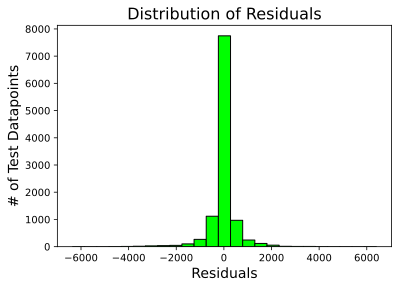

In [23]:
# Calculate the residuals by subtracting the predicted values from the actual test values
all_residuals = test_y - y_pred

# Set up the figure with custom size and resolution (DPI)
plt.figure(figsize=(6, 4), dpi = 150)

# Plot the histogram of residuals
plt.hist(all_residuals, bins = 25, color = 'lime', edgecolor = 'black')

# Label X and Y axes
plt.xlabel('Residuals', fontsize = 14)
plt.ylabel('# of Test Datapoints', fontsize = 14)

# Set the title of the plot
plt.title('Distribution of Residuals', fontsize = 16)

# Adjust the font size of x and y ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

plt.savefig('residual_plot.svg')

#### Scatter Plot of Predicted Vs. Actual Values

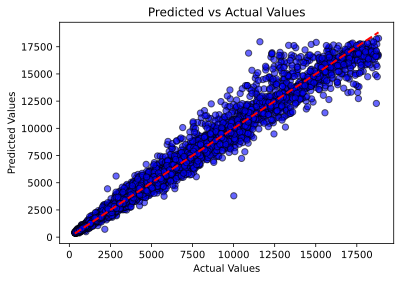

In [22]:
# Setting the figure size and resolution
plt.figure(figsize = (6, 4), dpi = 150)

# Scatter plot of actual vs predicted values
plt.scatter(test_y, y_pred, color = 'blue', alpha = 0.6, edgecolor = 'black', s = 40)

# 45-degree reference line (perfect predictions)
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color = 'red', linestyle = '--', lw = 2)

# Axis labels and title
plt.xlabel('Actual Values', fontsize = 10)
plt.ylabel('Predicted Values', fontsize = 10)
plt.title('Predicted vs Actual Values', fontsize = 12)

# Adjust ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

plt.savefig('pred_vs_actual.svg')

#### Feature Importance Plot

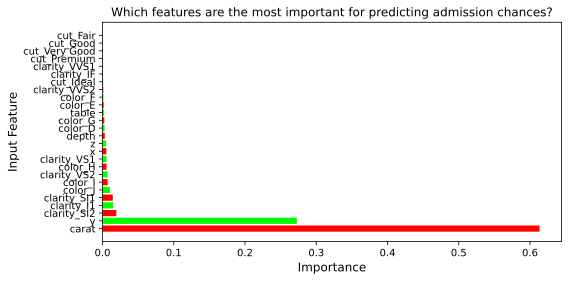

In [12]:
# Storing importance values from the trained model
importance = reg.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Bar plot
plt.figure(figsize=(8, 4))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['red', 'lime'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important for predicting admission chances?', fontsize = 12) 
plt.yticks(fontsize = 10) # fontsize of yticks
plt.xticks(fontsize = 10) # fontsize of xticks

plt.tight_layout();

plt.savefig('feature_imp.svg')

#### **Prediction Intervals using MAPIE Regressor**

***MAPIE: Model Agnostic Prediction Interval Estimator***

- It is a Python library designed to estimate prediction intervals in a **model-agnostic way**.
- It can be used with **any machine learning model**, including linear models, decision trees, ensemble methods, and neural networks.

[**See this link for detailed description on `MAPIE`**](https://mapie.readthedocs.io/en/latest/generated/mapie.regression.MapieRegressor.html)

In [13]:
# Define MAPIE regressor
mapie = MapieRegressor(estimator = reg, # Prediction model to use
                       n_jobs = -1, #-1 means using all available CPUs; suggested 4-5 cores
                       random_state = 42)

# Fit mapie regressor on training data
start = time.time()  
mapie.fit(train_X, train_y)
stop = time.time()             
print(f"Training time: {stop - start}s")

alpha = 0.1 # For 90% confidence level

# Use mapie.predict() to get predicted values and intervals
y_test_pred, y_test_pis = mapie.predict(test_X, alpha = alpha)
#pis = prediction intervals of each data point

Training time: 57.577974796295166s


In [14]:
# Predicted values
y_test_pred

array([ 567.86, 2316.  , 1207.69, ...,  769.66, 9593.91, 3877.06])

In [15]:
# Prediction Intervals
y_test_pis

array([[[ -155.33  ],
        [ 1268.79  ]],

       [[ 1617.17  ],
        [ 3045.62  ]],

       [[  496.64  ],
        [ 1923.6   ]],

       ...,

       [[   79.    ],
        [ 1503.4775]],

       [[ 8833.08  ],
        [10288.83  ]],

       [[ 3113.65  ],
        [ 4560.62  ]]])

In [16]:
# Storing results in a dataframe
predictions = test_y.to_frame()
predictions.columns = ['Actual Value']
predictions["Predicted Value"] = y_test_pred.round(2)
predictions["Lower Value"] = y_test_pis[:, 0].round(2)
predictions["Upper Value"] = y_test_pis[:, 1].round(2)

# Take a quick look
predictions.tail(5)

Actual Value  Predicted Value  Lower Value  Upper Value
44081          1554          1745.27      1038.74      2464.05
23713           633           610.97      -102.26      1322.61
31375           761           769.66        79.00      1503.48
21772          9836          9593.91      8833.08     10288.83
4998           3742          3877.06      3113.65      4560.62

### **Coverage Calculation**
- **Coverage** refers to the proportion of true/actual values that fall within the prediction intervals generated by a model.

- It is a measure of how well the prediction intervals capture the actual values.

  $\text{Coverage} = \frac{\text{Number of actual values within prediction intervals}}{\text{Total number of actual values}}$

In [17]:
coverage = regression_coverage_score(test_y,           # Actual values
                                     y_test_pis[:, 0], # Lower bound of prediction intervals
                                     y_test_pis[:, 1]) # Upper bound of prediction intervals

coverage_percentage = coverage * 100
print(f"Coverage: {coverage_percentage:.2f}%")

Coverage: 91.19%


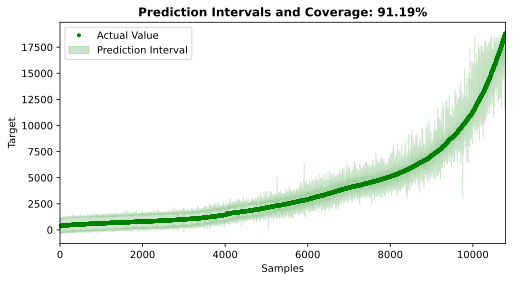

In [20]:
# Sort the predictions by 'Actual Value' for better visualization and reset the index
sorted_predictions = predictions.sort_values(by=['Actual Value']).reset_index(drop=True)

# Create a figure and axis object with specified size and resolution
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the actual values with green dots
plt.plot(sorted_predictions["Actual Value"], 'go', markersize=3, label="Actual Value")

# Fill the area between the lower and upper bounds of the prediction intervals with semi-transparent green color
plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["Lower Value"],
                 sorted_predictions["Upper Value"],
                 alpha=0.2, color="green", label="Prediction Interval")

# Set font size for x and y ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Set the limit for the x-axis to cover the range of samples
plt.xlim([0, len(sorted_predictions)])

# Label the x-axis and y-axis with appropriate font size
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Target", fontsize=10)

# Add a title to the plot, including the coverage percentage, with bold formatting
plt.title(f"Prediction Intervals and Coverage: {coverage_percentage:.2f}%", fontsize=12, fontweight="bold")

# Add a legend to the plot, placed in the upper left, with specified font size
plt.legend(loc="upper left", fontsize=10);

plt.savefig('coverage.svg')

### Save Model

In [19]:
# Creating the file where we want to write the model
reg_pickle = open('reg_diamond.pickle', 'wb') 

# Write RF model to the file
pickle.dump(mapie, reg_pickle) 

# Close the file
reg_pickle.close()